In [34]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm
import random
from collections import defaultdict
import functools

from scipy.spatial import distance_matrix
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.nn as gnn
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn.pool import global_mean_pool

from classes.cube_classes import Cube3State, Cube3
from generate.generate_states import ids_to_color
from utils.random_seed import seed_worker, seed_all, init_weights
from utils.compressions import *

torch.set_default_dtype(torch.float64)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
df = pd.read_pickle('data/5_moves_dataset_single.pkl')

In [3]:
def indices_to_position(indices):
    pos_array = np.array([
        [0.5, 0.5, 0], [1.5, 0.5, 0], [2.5, 0.5, 0],
        [0.5, 1.5, 0], [1.5, 1.5, 0], [2.5, 1.5, 0],
        [0.5, 2.5, 0], [1.5, 2.5, 0], [2.5, 2.5, 0],
        
        [2.5, 0.5, 3], [1.5, 0.5, 3], [0.5, 0.5, 3],
        [2.5, 1.5, 3], [1.5, 1.5, 3], [0.5, 1.5, 3],
        [2.5, 2.5, 3], [1.5, 2.5, 3], [0.5, 2.5, 3],
        
        [2.5, 0, 2.5], [2.5, 0, 1.5], [2.5, 0, 0.5],
        [1.5, 0, 2.5], [1.5, 0, 1.5], [1.5, 0, 0.5],
        [0.5, 0, 2.5], [0.5, 0, 1.5], [0.5, 0, 0.5],
        
        [0.5, 3, 2.5], [0.5, 3, 1.5], [0.5, 3, 0.5],
        [1.5, 3, 2.5], [1.5, 3, 1.5], [1.5, 3, 0.5],
        [2.5, 3, 2.5], [2.5, 3, 1.5], [2.5, 3, 0.5],
        
        [3, 2.5, 2.5], [3, 2.5, 1.5], [3, 2.5, 0.5],
        [3, 1.5, 2.5], [3, 1.5, 1.5], [3, 1.5, 0.5],
        [3, 0.5, 2.5], [3, 0.5, 1.5], [3, 0.5, 0.5],
        
        [0, 0.5, 2.5], [0, 0.5, 1.5], [0, 0.5, 0.5],
        [0, 1.5, 2.5], [0, 1.5, 1.5], [0, 1.5, 0.5],
        [0, 2.5, 2.5], [0, 2.5, 1.5], [0, 2.5, 0.5],
    ])
    return pos_array[np.array(indices)]

## Network

In [201]:
class GCNNet(torch.nn.Module):
    def __init__(self, hidden_channels, node_features_size=10):
        super(GCNNet, self).__init__()
        self.conv1 = gnn.GCNConv(node_features_size, hidden_channels)
        self.conv2 = gnn.GCNConv(hidden_channels, hidden_channels)
        self.lin = nn.Linear(hidden_channels, 1)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
#         print(x.size(), edge_index.size(), edge_attr.size())
        x = F.relu(self.conv1(x, edge_index, edge_attr))
        x = self.conv2(x, edge_index, edge_attr)
        x = global_mean_pool(x, data.batch)
        x = self.lin(x)
        return x

## 1. SparseGraphNet

In [155]:
@functools.lru_cache
def calc_distances(filtered_indices):
    vertices = indices_to_position(filtered_indices)
    dist_mat = distance_matrix(vertices, vertices)  # pouze se stredem
    return dist_mat

In [156]:
def find_middle(vertices):
    for vertex in vertices:
        if (vertex[0] == vertex[1] == 1.5) or (vertex[0] == vertex[2] == 1.5) or (vertex[1] == vertex[2] == 1.5):
            return vertex
    return None

In [195]:
def create_sparse_graph_data_obj(colors, distance_from_goal, node_features_size, verbose=False, aggregate=False, for_hashing=False):
    indices = np.arange(54)
    colors = np.array(colors)
    node_features = np.ones((54, node_features_size))
    edge_index = []
    edge_attr = []
    curr_idx = 0
    for color in range(6):
        filtered_indices = indices[colors == color]
        position_filtered_indices = indices_to_position(filtered_indices)
        middle = find_middle(position_filtered_indices)
        distances = distance_matrix(position_filtered_indices, middle.reshape(1, -1))
        ctr = 0
        for i in range(len(filtered_indices)):
#             print(position_filtered_indices[i])
#             print(middle)
            if (position_filtered_indices[i] == middle).all():
                continue
            node_i = curr_idx + ctr + 1
            node_j = curr_idx
            edge_index.append([node_i, node_j])
            edge_attr.append(distances[i].item())
            edge_index.append([node_j, node_i])
            edge_attr.append(distances[i].item())
            ctr += 1
        curr_idx += len(filtered_indices)
    y = distance_from_goal
    data = Data(x=torch.Tensor(node_features), edge_index=torch.Tensor(edge_index).T.long() , edge_attr=torch.Tensor(edge_attr).unsqueeze(1), y=torch.Tensor([y]))
    return data

In [196]:
data_list_sparse_graph = []
for _, row in tqdm(df.iterrows()):
    data_list_sparse_graph.append(create_sparse_graph_data_obj(row['colors'], row['distance'], node_features_size=10))

105045it [04:52, 359.73it/s]


In [197]:
loader_sparseGraph = DataLoader(data_list_sparse_graph, batch_size=128)

In [202]:
netSparseGraph = GCNNet(10)

In [203]:
data_list_sparse_graph[0].edge_attr.size()

torch.Size([96, 1])

In [204]:
## Training loop
optimizer = torch.optim.Adam(netSparseGraph.parameters(), lr=0.001)

for epoch in range(10):
    netSparseGraph.train()
    total = 0
    total_loss = 0.0
    for i, data in tqdm(enumerate(loader_sparseGraph)):
        optimizer.zero_grad()
        out = netSparseGraph(data)
        loss = F.mse_loss(out.squeeze(), data.y.squeeze(), reduction='sum')
        loss.backward()
        total_loss += loss.item()
        total += data.y.size(0)
        optimizer.step()
    if (epoch+1) % 1 == 0:
        print(f'Epoch {epoch+1}: train loss {total_loss/total:0.4f}')

821it [00:52, 15.74it/s]
2it [00:00, 16.79it/s]

Epoch 1: train loss 1.7456


821it [00:48, 16.93it/s]
2it [00:00, 17.93it/s]

Epoch 2: train loss 0.0559


821it [00:47, 17.30it/s]
5it [00:00, 42.55it/s]

Epoch 3: train loss 0.0552


821it [00:47, 17.31it/s]
2it [00:00, 17.91it/s]

Epoch 4: train loss 0.0549


205it [00:12, 16.69it/s]


KeyboardInterrupt: 

### Activation compressions

In [137]:
networksSparseGraph = create_networks(NetworkClass=GCNNet, network_args={'hidden_channels': 16}, num_of_networks=10)
distance_all_acts_sparse_graph = calculate_all_dicts_from_activations(df=df, max_distance=5, input_handling_func=create_sparse_graph_data_obj, networks=networksSparseGraph, is_graph_nn=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 93840/93840 [56:30<00:00, 27.68it/s]


In [133]:
distance_all_acts_sparse_graph[0]

defaultdict(list,
            {(69020383,
              -38525560,
              49564902,
              82223326,
              1741263,
              34060030,
              13740577,
              5245546,
              108666769,
              26535017): [(0, [["U'"]]),
              (1, [["R'"]]),
              (2, [["D'"]]),
              (3, [["L'"]]),
              (4, [["F'"]]),
              (5, [["B'"]]),
              (6, [['U']]),
              (7, [['R']]),
              (8, [['D']]),
              (9, [['L']]),
              (10, [['F']]),
              (11, [['B']])]})

In [138]:
with open('data/temp/distance_all_acts_sparse_graph.pkl', 'wb') as f:
    pickle.dump(distance_all_acts_sparse_graph, f)

In [139]:
set_intersections_activations_sparse_graph = compute_set_intersections(distance_all_acts_sparse_graph)

Intersection size between sets 1 AND 2: 0
Intersection size between sets 1 AND 3: 0
Intersection size between sets 1 AND 4: 0
Intersection size between sets 1 AND 5: 0
Intersection size between sets 2 AND 3: 0
Intersection size between sets 2 AND 4: 0
Intersection size between sets 2 AND 5: 0
Intersection size between sets 3 AND 4: 0
Intersection size between sets 3 AND 5: 0
Intersection size between sets 4 AND 5: 0


In [ ]:
# INTERSECTION_BETWEEN = (2,3)
# common_activation = list(set_intersections_activations_sparse_graph[INTERSECTION_BETWEEN])[0]
# gen1 = distance_all_acts_sparse_graph[INTERSECTION_BETWEEN[0] - 1][common_activation][0][1][0]
# print(gen1)
# gen2 = distance_all_acts_sparse_graph[INTERSECTION_BETWEEN[1] - 1][common_activation][0][1][0]
# print(gen2)

# cube1 = pc.Cube()
# print(' '.join(gen1))
# cube1(' '.join(gen1))
# display(cube1)

# cube2 = pc.Cube()
# print(' '.join(gen2))
# cube2(' '.join(gen2))
# display(cube2)

In [ ]:
# common_activation

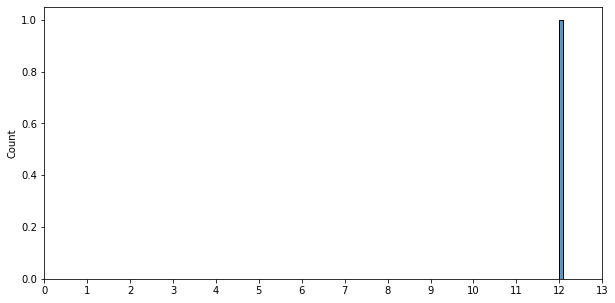

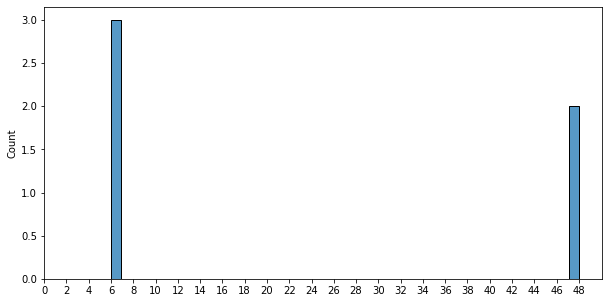

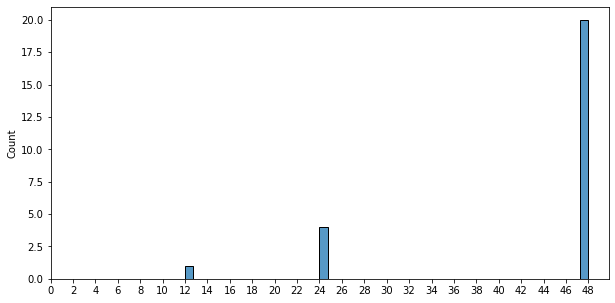

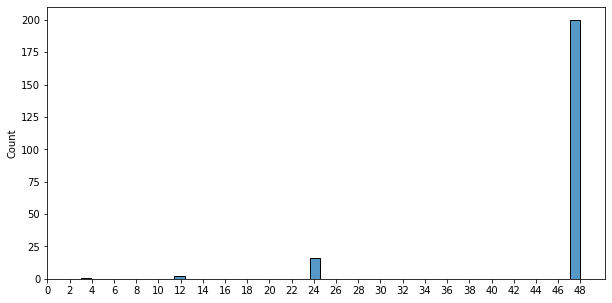

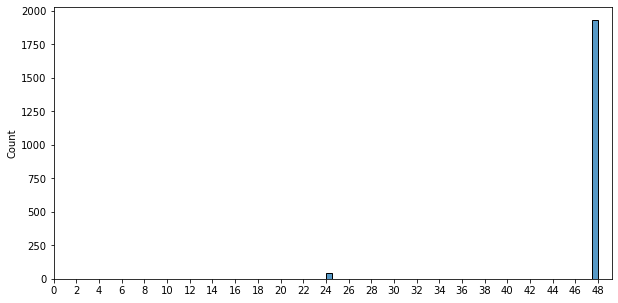

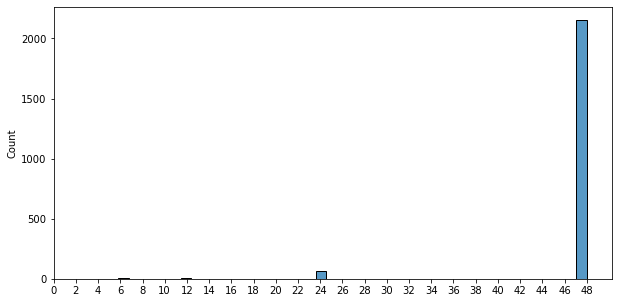

In [140]:
plot_distance_compressions(distance_all_acts_sparse_graph, 'sparseGraphNet/from_activations')

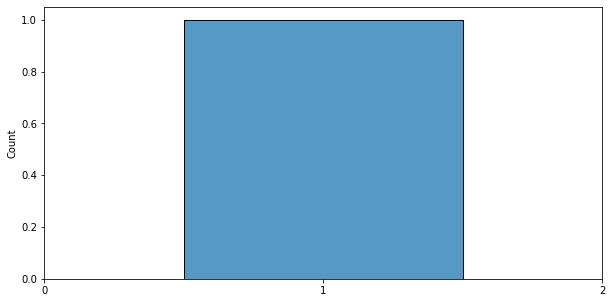

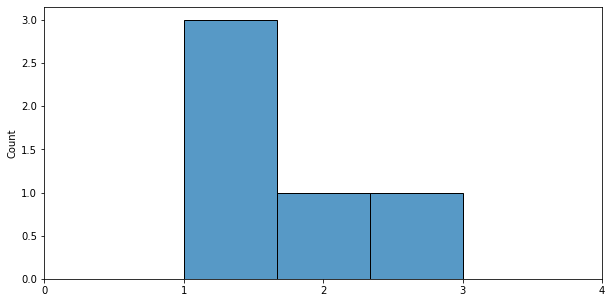

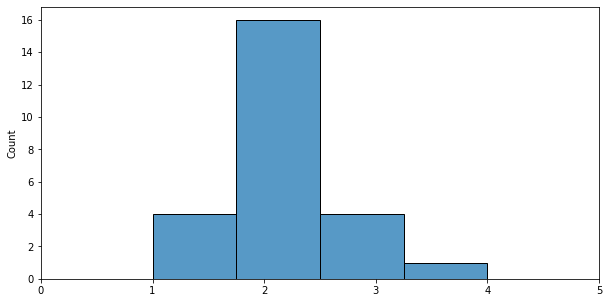

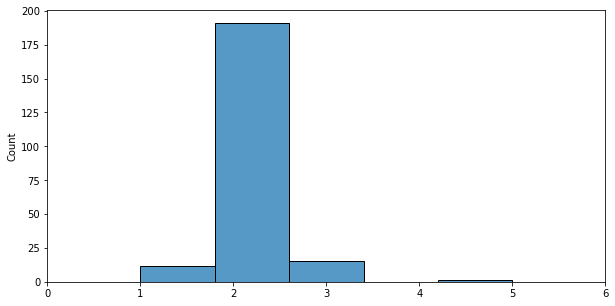

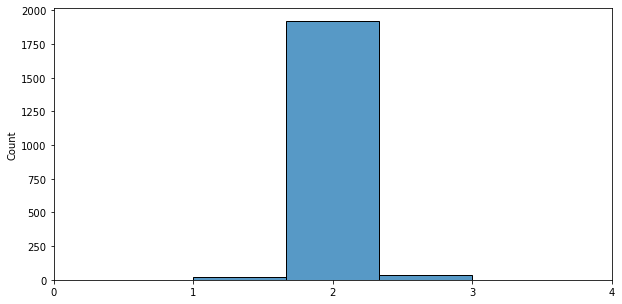

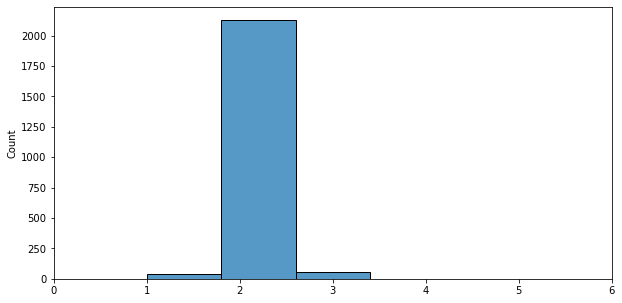

In [142]:
plot_class_ids_per_compressions(distance_all_acts_sparse_graph, df, 'sparseGraphNet/from_activations')

## 2. CompleteGraphsNet

In [4]:
@functools.lru_cache
def calc_distances(filtered_indices):
    vertices = indices_to_position(filtered_indices)
    dist_mat = distance_matrix(vertices, vertices)  # pouze se stredem
    return dist_mat

In [112]:
def create_complete_graph_data_obj(colors, distance_from_goal, node_features_size, verbose=False, aggregate=False, for_hashing=False):
    indices = np.arange(54)
    colors = np.array(colors)
    node_features = np.ones((54, node_features_size))
    edge_index = []
    edge_attr = []
    curr_idx = 0
    for color in range(6):
        filtered_indices = indices[colors == color]
        dist_mat = calc_distances(tuple(filtered_indices))
        for i in range(len(filtered_indices)):
            for j in range(len(filtered_indices)):
                node_i = curr_idx + i
                node_j = curr_idx + j
                edge_index.append([node_i, node_j])
                edge_attr.append(dist_mat[i,j])
        curr_idx += len(filtered_indices)
    y = distance_from_goal
    data = Data(x=torch.Tensor(node_features), edge_index=torch.Tensor(edge_index).T.long() , edge_attr=torch.Tensor(edge_attr).unsqueeze(1), y=torch.Tensor([y]))
    return data

In [113]:
data_list_complete_graph = []
for _, row in tqdm(df.iterrows()):
    data_list_complete_graph.append(create_complete_graph_data_obj(row['colors'], row['distance'], node_features_size=10))

105045it [06:23, 274.23it/s] 


In [153]:
loader_compGraph = DataLoader(data_list_complete_graph, batch_size=128)

In [148]:
netCompGraph = GCNNet(10)

In [151]:
## Training loop
optimizer = torch.optim.Adam(netCompGraph.parameters(), lr=0.001)

for epoch in range(10):
    netCompGraph.train()
    total = 0
    total_loss = 0.0
    for i, data in tqdm(enumerate(loader_compGraph)):
        optimizer.zero_grad()
        out = netCompGraph(data)
        loss = F.mse_loss(out.squeeze(), data.y.squeeze(), reduction='sum')
        loss.backward()
        total_loss += loss.item()
        total += data.y.size(0)
        optimizer.step()
    if (epoch+1) % 1 == 0:
        print(f'Epoch {epoch+1}: train loss {total_loss/total:0.4f}')

821it [01:40,  8.20it/s]
1it [00:00,  9.41it/s]

Epoch 1: train loss 0.7268


821it [01:24,  9.76it/s]
1it [00:00,  9.86it/s]

Epoch 2: train loss 0.0551


821it [01:28,  9.24it/s]
2it [00:00, 10.62it/s]

Epoch 3: train loss 0.0547


821it [01:23,  9.88it/s]
0it [00:00, ?it/s]

Epoch 4: train loss 0.0547


283it [00:28,  9.87it/s]


KeyboardInterrupt: 

### Activation compressions

In [137]:
networksCompGraph = create_networks(NetworkClass=GCNNet, network_args={'hidden_channels': 16}, num_of_networks=10)
distance_all_acts_complete_graph = calculate_all_dicts_from_activations(df=df, max_distance=5, input_handling_func=create_complete_graph_data_obj, networks=networksCompGraph, is_graph_nn=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 93840/93840 [56:30<00:00, 27.68it/s]


In [133]:
distance_all_acts_complete_graph[0]

defaultdict(list,
            {(69020383,
              -38525560,
              49564902,
              82223326,
              1741263,
              34060030,
              13740577,
              5245546,
              108666769,
              26535017): [(0, [["U'"]]),
              (1, [["R'"]]),
              (2, [["D'"]]),
              (3, [["L'"]]),
              (4, [["F'"]]),
              (5, [["B'"]]),
              (6, [['U']]),
              (7, [['R']]),
              (8, [['D']]),
              (9, [['L']]),
              (10, [['F']]),
              (11, [['B']])]})

In [138]:
with open('data/temp/distance_all_acts_complete_graph.pkl', 'wb') as f:
    pickle.dump(distance_all_acts_complete_graph, f)

In [139]:
set_intersections_activations_complete_graph = compute_set_intersections(distance_all_acts_complete_graph)

Intersection size between sets 1 AND 2: 0
Intersection size between sets 1 AND 3: 0
Intersection size between sets 1 AND 4: 0
Intersection size between sets 1 AND 5: 0
Intersection size between sets 2 AND 3: 0
Intersection size between sets 2 AND 4: 0
Intersection size between sets 2 AND 5: 0
Intersection size between sets 3 AND 4: 0
Intersection size between sets 3 AND 5: 0
Intersection size between sets 4 AND 5: 0


In [ ]:
# INTERSECTION_BETWEEN = (2,3)
# common_activation = list(set_intersections_activations_complete_graph[INTERSECTION_BETWEEN])[0]
# gen1 = distance_all_acts_complete_graph[INTERSECTION_BETWEEN[0] - 1][common_activation][0][1][0]
# print(gen1)
# gen2 = distance_all_acts_complete_graph[INTERSECTION_BETWEEN[1] - 1][common_activation][0][1][0]
# print(gen2)

# cube1 = pc.Cube()
# print(' '.join(gen1))
# cube1(' '.join(gen1))
# display(cube1)

# cube2 = pc.Cube()
# print(' '.join(gen2))
# cube2(' '.join(gen2))
# display(cube2)

In [ ]:
# common_activation

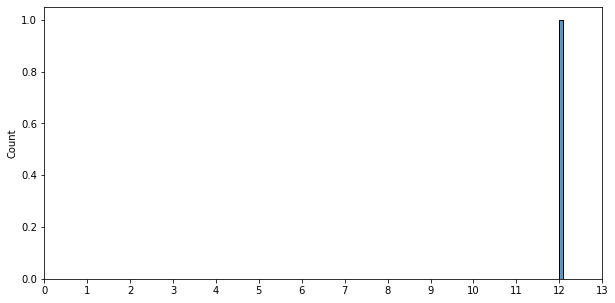

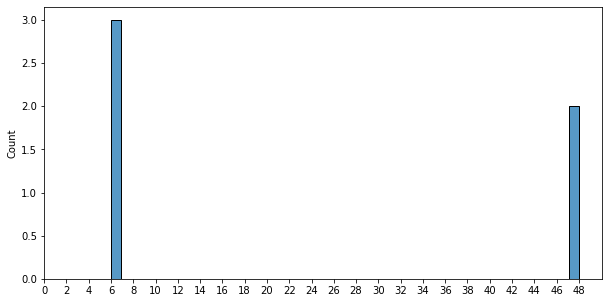

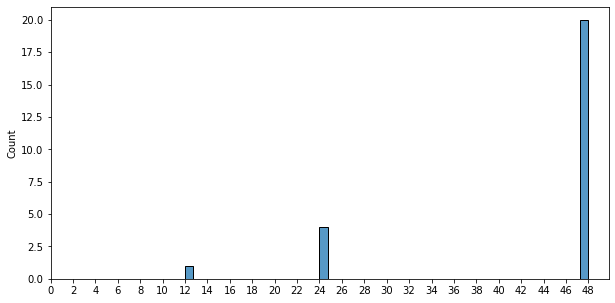

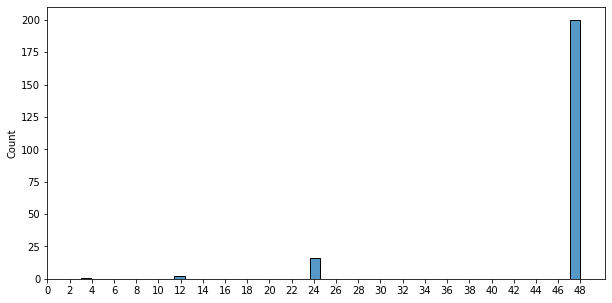

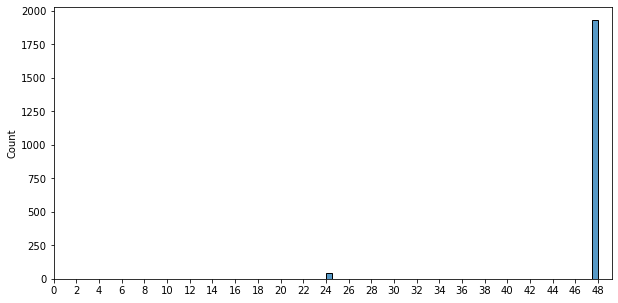

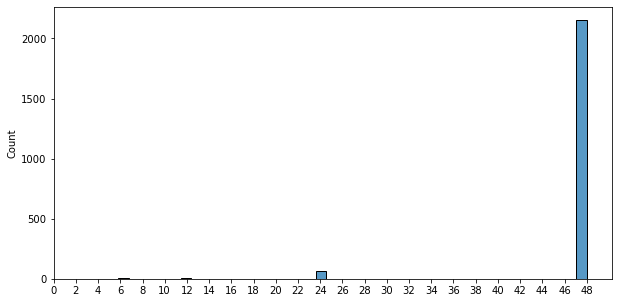

In [140]:
plot_distance_compressions(distance_all_acts_complete_graph, 'completeGraphNet/from_activations')

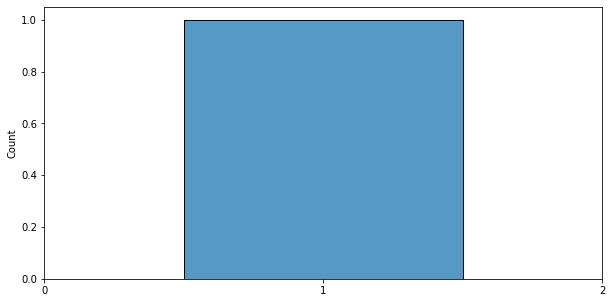

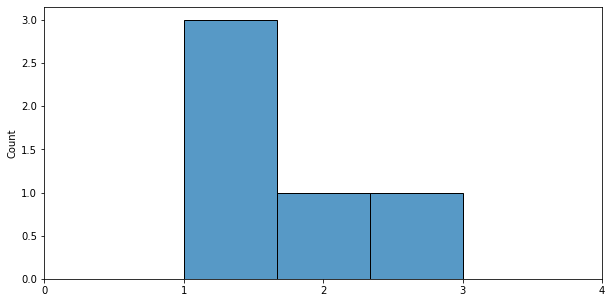

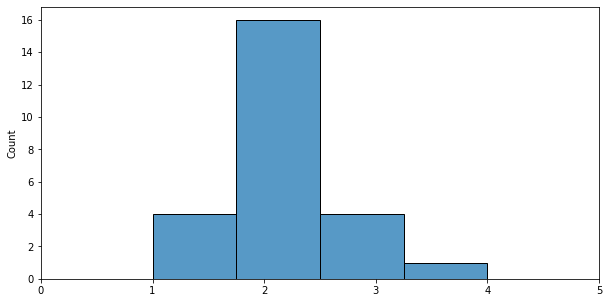

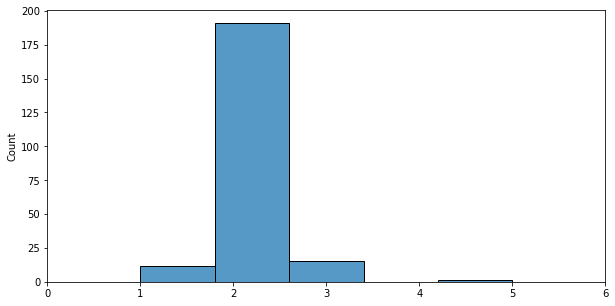

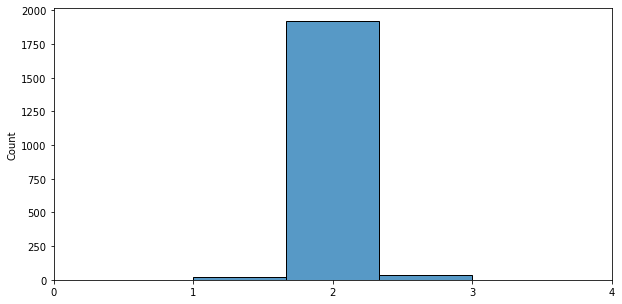

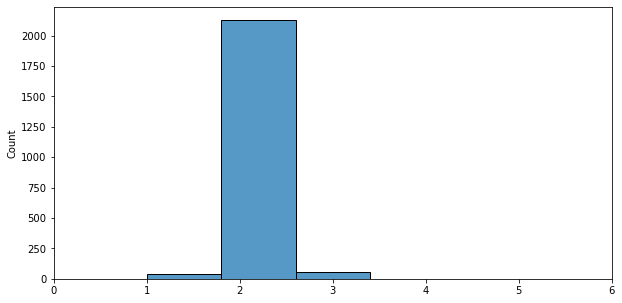

In [142]:
plot_class_ids_per_compressions(distance_all_acts_complete_graph, df, 'completeGraphNet/from_activations')